# Setting up the notebook

In [ ]:
!wget https://raw.githubusercontent.com/badralbanna/FTN/master/ndim.py

In [1]:
import numpy as np
from scipy.linalg import eig
import matplotlib.pylab as plt
from matplotlib import cm
from numpy import sin, cos, tan, exp, pi, e
from ndim import *

# Defining the variables and equations of motion

In [2]:
X_LABEL = "V"
Y_LABEL = "w"
I = 0.0

# Note that these functions depend on but this can be ignored if there is no time dependance
def DXDT(x, y, t):
    return(-x*(x-1)*(x-0.1) - y + I)
    
def DYDT(x, y, t):
    return(x - y)

# Rendering the phase portrait

In [21]:
# Setting plotting defaults
X_MIN = -.2 # minimum X value shown
X_MAX = 1.1 # maximum X value shown
Y_MIN = -.2 # minimum Y value shown
Y_MAX = 1.1 # maximum Y value shown

RES = 0.1 # spacing between arrows for the quiver plot), don't need to change
Q_SCALE = 1.0 # scale factor to stretch quivers when plotted (for visibility), don't need to change

Critical points found at:
[(0.0, 0.0)]



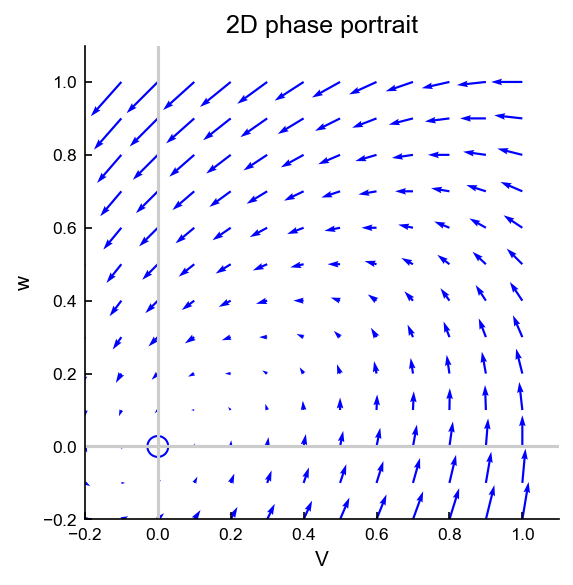

In [22]:
ax = plot_2D_phase_space(DXDT, DYDT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX), res=RES, q_scale=Q_SCALE, x_label=X_LABEL, y_label=Y_LABEL)

# Simulating solutions to the system (using RK2)

In [17]:
DT = 0.001 # simulation timestep

X_0 = 0.2 # starting x value
Y_0 = 0 # starting y value
T_f = 30 # final time, initial time is always 0

X_MIN = -.2 # minimum X value shown
X_MAX = 1.1 # maximum X value shown
Y_MIN = -.2 # minimum X value shown
Y_MAX = 1.1 # maximum X value shown

RES = 0.1 # spacing between arrows for the quiver plot), don't need to change
Q_SCALE = 1.0 # scale factor to stretch quivers when plotted (for visibility), don't need to change

/Users/badr/opt/anaconda3/envs/py3-qn/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


Critical points found at:
[(0.0, 0.0)]



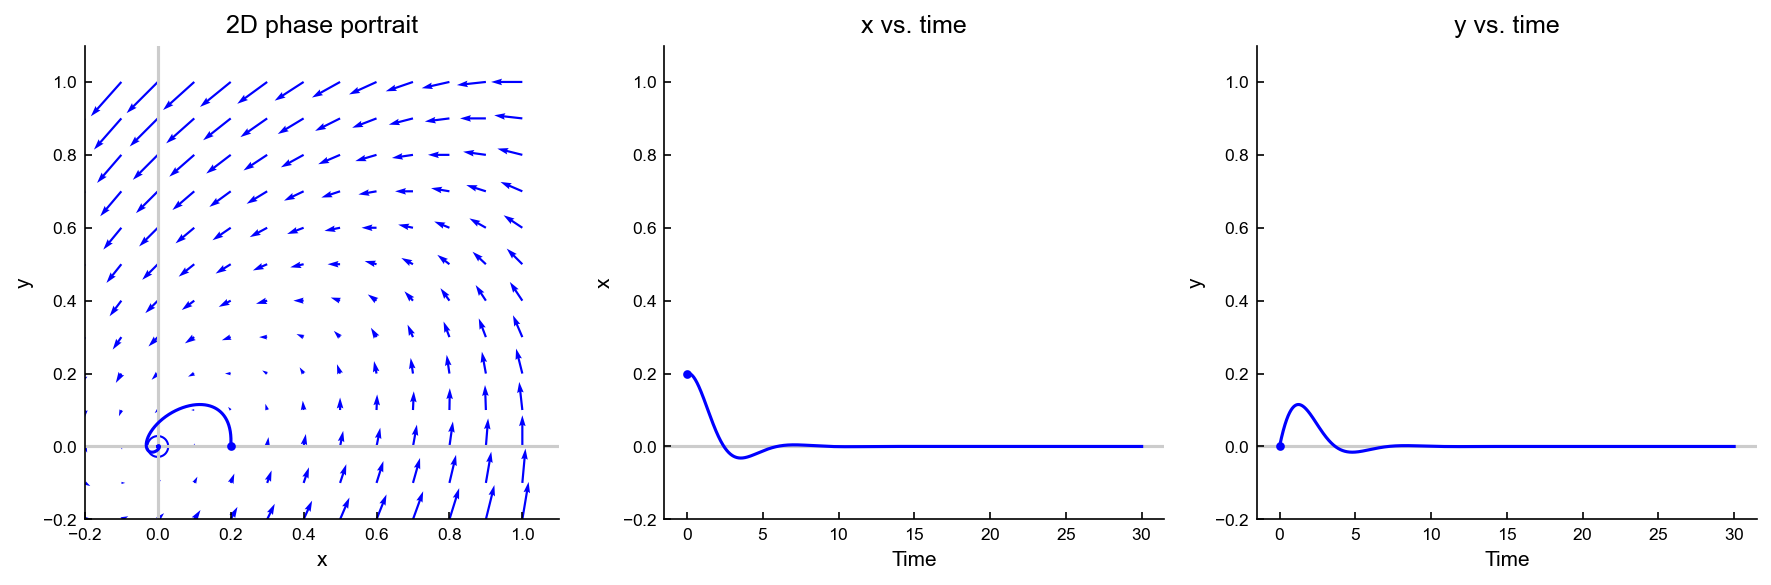

In [18]:
ax, ax_x, ax_y = plot_2D_solutions(T_f, [X_0], [Y_0], DXDT, DYDT, [find_next_point_midpoint_nD], colors=['b'], dt=DT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX), res=RES, q_scale=Q_SCALE)

## Plotting a set of trajectories

In [15]:
X_MIN = -.2 # minimum X value shown
X_MAX = 1.1 # maximum X value shown
Y_MIN = -.2 # minimum Y value shown
Y_MAX = 1.1 # maximum Y value shown

X_0s = [-.1, 0, .1, .2] # list of starting X values
Y_0s = [-.01]*5 # list of starting Y values
T_f = 10 # Final simulation time, initial time is 0

RES = 0.1 # spacing between arrows for the quiver plot), don't need to change
Q_SCALE = 1.0 # scale factor to stretch quivers when plotted (for visibility), don't need to change

/Users/badr/opt/anaconda3/envs/py3-qn/lib/python3.8/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: xtol=0.000000 is too small, no further improvement in the approximate
  solution is possible.
  warnings.warn(msg, RuntimeWarning)


Critical points found at:
[(0.0, 0.0)]



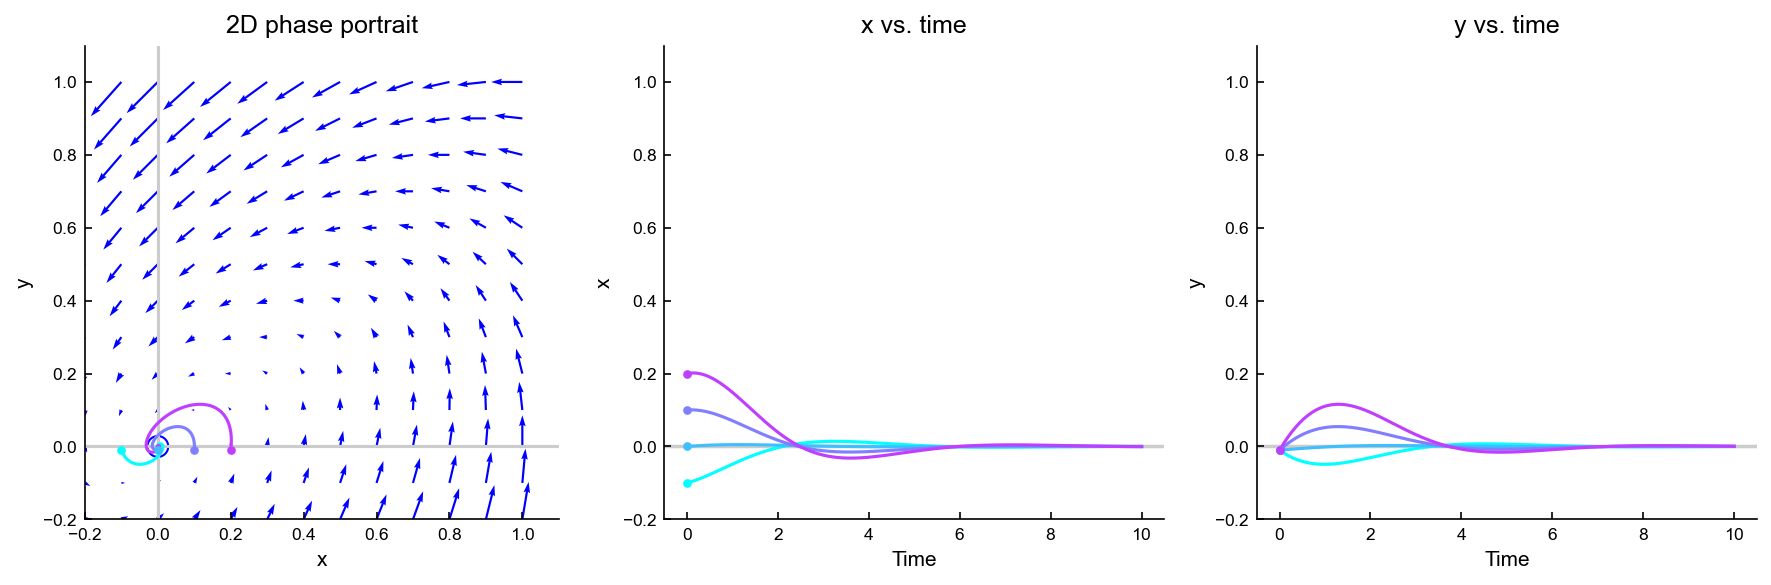

In [16]:
ax, ax_x, ax_y = plot_2D_solutions(T_f, X_0s, Y_0s, DXDT, DYDT, [find_next_point_midpoint_nD], colors=[cm.cool(i / float(len(X_0s))) for i in range(len(X_0s))], dt=0.001, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX), res=RES, q_scale=Q_SCALE)

# Approximating dynamics near the critical points

In [33]:
# Some functions to "linearize" a system near crtical points and find eigenvalues and vectors there 

# Function to "linearize" non-linear systems near a point (do not change)
def linearize_2D(x, y, dxdt, dydt, D=0.000001, t=0):
    dx_func = lambda x, y, t=t: dxdt(x, y, t)
    dy_func = lambda x, y, t=t: dydt(x, y, t)
    L = np.array(
        [[(dx_func(x+D,y) - dx_func(x-D,y, t=0)) / (2*D), (dx_func(x,y+D, t) - dx_func(x,y-D)) / (2*D)], 
        [(dy_func(x+D,y) - dy_func(x-D,y)) / (2*D), (dy_func(x,y+D) - dy_func(x,y-D)) / (2*D)]]
    )
    return(L)

# Function to "linearize" non-linear system near all critical points 
def linearize_all_2D_critical_points(dxdt, dydt, t=0, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX)):
    cp_x, cp_y = find_2D_critical_points(dxdt, dydt, t=t, xlim=xlim, ylim=ylim)
    Ls = []
    for i, (x, y) in enumerate(zip(cp_x, cp_y)):
        L = linearize_2D(x, y, dxdt, dydt)
        Ls.append(L)
        print(f" At critical point #{i}, ({x}, {y}), the functions are approximated by \n {L}\n")
    return Ls, cp_x, cp_y

# Function to find and print eigenvalues and eigenvectors of a matrix (do not change)
def find_eigenvalues_and_eigenvectors(M):
    vals, mat = eig(M)
    for i in range(len(vals)):
        if np.imag(vals[i]) == 0.0:
            vals = np.array(vals, dtype='float')
        print(f"\tEigenvalue {i+1} is {vals[i]:.3}, with vector ({mat[0,i]:.3}, {mat[1,i]:.3})")
    return vals, mat

# A function to find and print eigenvalues and eigenvectors at all crtiical points (do not change)
def find_all_2D_critcal_eigenvalues_and_eigenvectors(dxdt, dydt, t=0, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX)):
    Ls, cp_x, cp_y = linearize_all_2D_critical_points(dxdt, dydt, t=t)
    vals = []
    mats = []
    for i, (L, x, y) in enumerate(zip(Ls, cp_x, cp_y)):
        print(f"At critical point #{i}, ({x}, {y}),")
        val, mat = find_eigenvalues_and_eigenvectors(Ls[i])
        print("")
        vals.append(val)
        mats.append(mat)
    return vals, mats, Ls, cp_x, cp_y

In [34]:
Ls, cp_x, cp_y = linearize_all_2D_critical_points(DXDT, DYDT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX))    

Critical points found at:
[(0.0, 0.0)]

 At critical point #0, (0.0, 0.0), the functions are approximated by 
 [[ -2. -20.]
 [  2.  -2.]]



In [36]:
vals, mats, Ls, cp_x, cp_y = find_all_2D_critcal_eigenvalues_and_eigenvectors(DXDT, DYDT, xlim=(X_MIN, X_MAX), ylim=(Y_MIN, Y_MAX))

Critical points found at:
[(0.0, 0.0)]

 At critical point #0, (0.0, 0.0), the functions are approximated by 
 [[ -2. -20.]
 [  2.  -2.]]

At critical point #0, (0.0, 0.0),
	Eigenvalue 1 is (-2+6.32j), with vector ((0.953+0j), (-4.77e-13-0.302j))
	Eigenvalue 2 is (-2-6.32j), with vector ((0.953-0j), (-4.77e-13+0.302j))

